In [ ]:
# Import important libraries
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.stats import zscore

In [ ]:
# Load dataset
df = pd.read_csv('/content/Mall_Customers.csv')

In [ ]:
# Display the dataset
df.head()

,CustomerID,Genre,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [ ]:
# Initial inspection
print(df.info())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Genre                   200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB
None
       CustomerID         Age  Annual Income (k$)  Spending Score (1-100)
count  200.000000  200.000000          200.000000              200.000000
mean   100.500000   38.850000           60.560000               50.200000
std     57.879185   13.969007           26.264721               25.823522
min      1.000000   18.000000           15.000000                1.000000
25%     50.750000   28.750000           41.500000               34.750000
50%    100.500000   36.000000    

In [ ]:
print(df.isnull().sum())
print(f"Duplicates: {df.duplicated().sum()}")

CustomerID                0
Genre                     0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64
Duplicates: 0


**Data Preprocessing**

In [ ]:
# Encoding categorical variables
df['Genre'] = df['Genre'].map({'Male': 0, 'Female': 1})

In [ ]:
# Outlier Detection & Removal using Z-score
z_scores = np.abs(zscore(df[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']]))
df_clean = df[(z_scores < 3).all(axis=1)]

In [ ]:
# Feature Engineering
df_clean['Wealth'] = df_clean['Age'] * df_clean['Annual Income (k$)']

In [ ]:
# Scaling the features (RobustScaler for outlier robustness)
scaler = RobustScaler()
scaled_features = scaler.fit_transform(df_clean[['Age', 'Annual Income (k$)', 'Spending Score (1-100)', 'Wealth']])

In [ ]:
# PCA for 2D visualization
pca = PCA(n_components=2)
pca_data = pca.fit_transform(scaled_features)
df_clean['PCA1'] = pca_data[:, 0]
df_clean['PCA2'] = pca_data[:, 1]

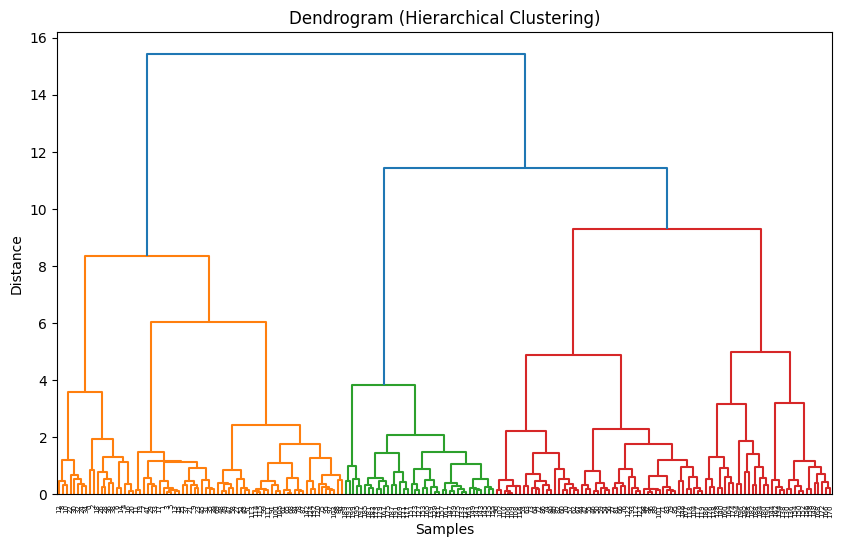

In [ ]:
# Dendrogram for Hierarchical Clustering
plt.figure(figsize=(10, 6))
linkage_matrix = linkage(scaled_features, method='ward')
dendrogram(linkage_matrix)
plt.title('Dendrogram (Hierarchical Clustering)')
plt.xlabel('Samples')
plt.ylabel('Distance')
plt.show()

In [ ]:
# --- KMeans Clustering ---
kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
df_clean['KMeans_Cluster'] = kmeans.fit_predict(scaled_features)

In [ ]:
# --- Agglomerative Clustering ---
agglo = AgglomerativeClustering(n_clusters=5)
df_clean['Agglomerative_Cluster'] = agglo.fit_predict(scaled_features)

In [ ]:
# --- DBSCAN ---
dbscan = DBSCAN(eps=0.8, min_samples=5)
df_clean['DBSCAN_Cluster'] = dbscan.fit_predict(scaled_features)

In [ ]:
# --- Gaussian Mixture Model (GMM) ---
gmm = GaussianMixture(n_components=5, random_state=42)
df_clean['GMM_Cluster'] = gmm.fit_predict(scaled_features)

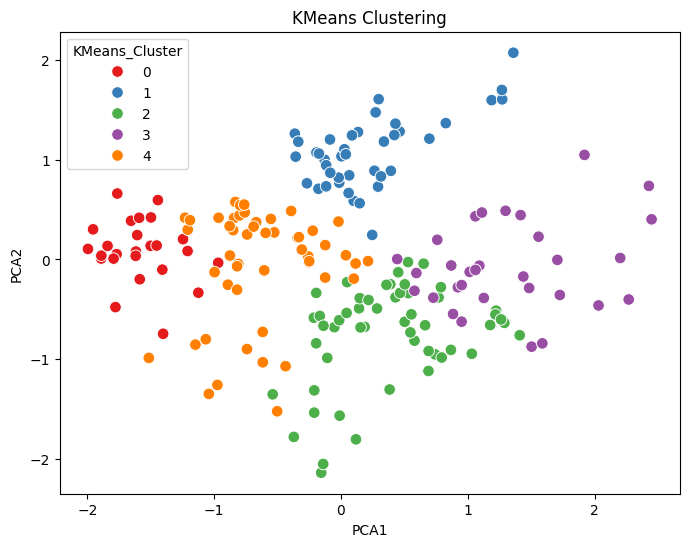

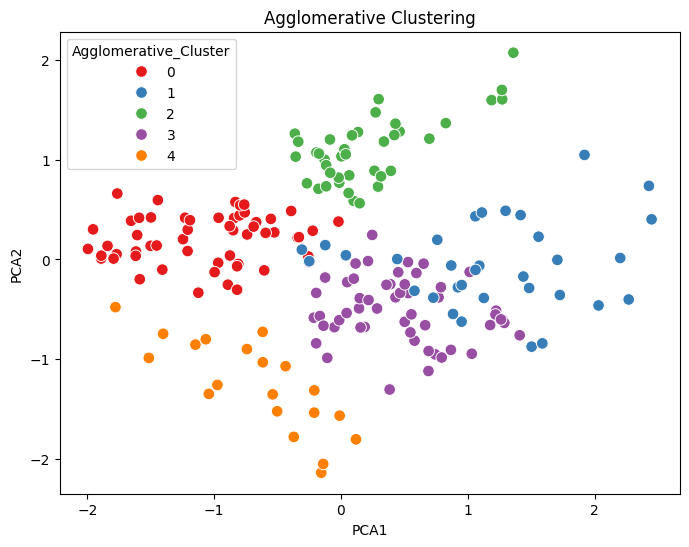

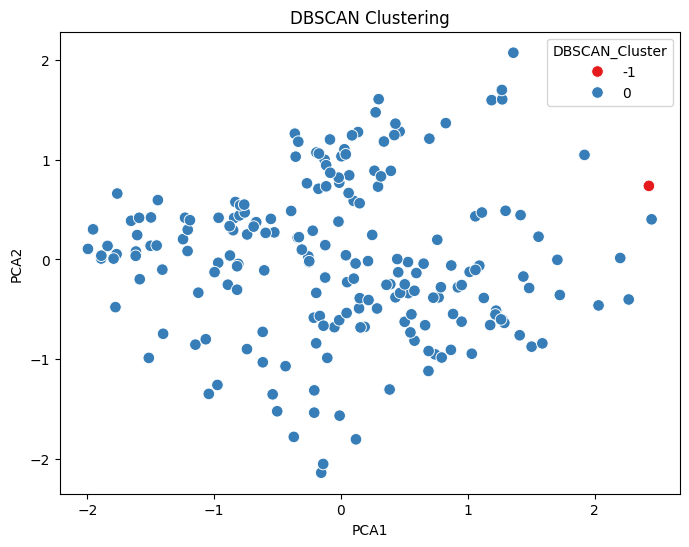

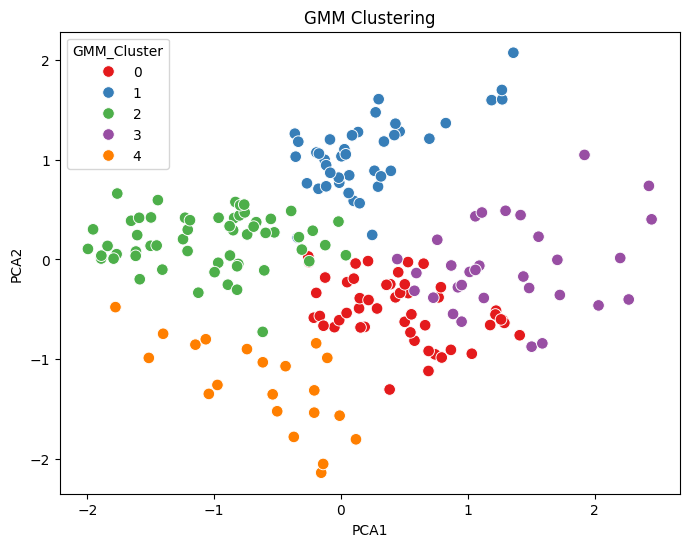

In [ ]:
# --- Visualization of Clusters in PCA space ---
def plot_clusters(title, cluster_col):
    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=df_clean, x='PCA1', y='PCA2', hue=cluster_col, palette='Set1', s=70)
    plt.title(f'{title} Clustering')
    plt.legend(title=cluster_col)
    plt.show()

plot_clusters('KMeans', 'KMeans_Cluster')
plot_clusters('Agglomerative', 'Agglomerative_Cluster')
plot_clusters('DBSCAN', 'DBSCAN_Cluster')
plot_clusters('GMM', 'GMM_Cluster')


In [ ]:
# --- Evaluation Metrics Function ---
def evaluate_clustering(X, labels, model_name):
    if len(set(labels)) <= 1:
        print(f"{model_name}: Only 1 cluster found. Skipping metrics.\n")
        return
    silhouette = silhouette_score(X, labels)
    ch_index = calinski_harabasz_score(X, labels)
    db_index = davies_bouldin_score(X, labels)
    print(f"{model_name} Evaluation:")
    print(f"  Silhouette Score: {silhouette:.4f}")
    print(f"  Calinski-Harabasz Index: {ch_index:.2f}")
    print(f"  Davies-Bouldin Score: {db_index:.4f}\n")

evaluate_clustering(scaled_features, df_clean['KMeans_Cluster'], 'KMeans')
evaluate_clustering(scaled_features, df_clean['Agglomerative_Cluster'], 'Agglomerative')
evaluate_clustering(scaled_features, df_clean['DBSCAN_Cluster'], 'DBSCAN')
evaluate_clustering(scaled_features, df_clean['GMM_Cluster'], 'GMM')

KMeans Evaluation:
  Silhouette Score: 0.3882
  Calinski-Harabasz Index: 121.19
  Davies-Bouldin Score: 0.9147

Agglomerative Evaluation:
  Silhouette Score: 0.4068
  Calinski-Harabasz Index: 115.75
  Davies-Bouldin Score: 0.9198

DBSCAN Evaluation:
  Silhouette Score: 0.3203
  Calinski-Harabasz Index: 3.68
  Davies-Bouldin Score: 0.4837

GMM Evaluation:
  Silhouette Score: 0.3973
  Calinski-Harabasz Index: 114.42
  Davies-Bouldin Score: 0.9294



In [ ]:
# --- Cluster Profiling ---
def cluster_profile(df, cluster_col):
    print(f"\n--- {cluster_col} Profiling ---\n")
    profile = df.groupby(cluster_col)[['Age', 'Annual Income (k$)', 'Spending Score (1-100)', 'Wealth']].mean()
    print(profile)
    print('\n')

cluster_profile(df_clean, 'KMeans_Cluster')
cluster_profile(df_clean, 'Agglomerative_Cluster')
cluster_profile(df_clean, 'GMM_Cluster')


--- KMeans_Cluster Profiling ---

                      Age  Annual Income (k$)  Spending Score (1-100)  \
KMeans_Cluster                                                          
0               25.480000           25.480000               75.440000   
1               32.875000           86.100000               81.525000   
2               56.166667           49.000000               43.222222   
3               44.387097           89.774194               18.483871   
4               28.180000           52.040000               39.720000   

                     Wealth  
KMeans_Cluster               
0                649.240000  
1               2820.150000  
2               2746.944444  
3               3947.064516  
4               1398.300000  



--- Agglomerative_Cluster Profiling ---

                             Age  Annual Income (k$)  Spending Score (1-100)  \
Agglomerative_Cluster                                                          
0                      24.962963       

In [ ]:
# --- Final Insights ---
print("\n--- Business Insights ---")
print("1. KMeans & Agglomerative clustering show distinct customer segments based on income, spending score, and wealth.")
print("2. DBSCAN detected outliers and noise points (label -1).")
print("3. GMM provides probabilistic clusters which may be useful for softer segmentation strategies.")
print("4. PCA helped visualize high-dimensional data for clustering validation.")


--- Business Insights ---
1. KMeans & Agglomerative clustering show distinct customer segments based on income, spending score, and wealth.
2. DBSCAN detected outliers and noise points (label -1).
3. GMM provides probabilistic clusters which may be useful for softer segmentation strategies.
4. PCA helped visualize high-dimensional data for clustering validation.
